# Import dependencies

In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to database

In [2]:
# Connect to sqlite database using SQLAlchemy ORM
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station

In [3]:
session = Session(engine)

## Temperature Analysis II

In [4]:
def calc_temps(start_date, end_date):
    results = session.query(Measurement.date, \
                            func.min(Measurement.tobs), \
                            func.avg(Measurement.tobs), \
                            func.max(Measurement.tobs)).\
                            group_by(Measurement.date).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date)
    
    df = pd.read_sql(results.statement, results.session.bind)
    
    return df

In [5]:
df_2016 = calc_temps("2016-08-01", "2016-08-07")
df_2016

,date,min_1,avg_1,max_1
0,2016-08-01,73.0,76.166667,78.0
1,2016-08-02,72.0,76.571429,80.0
2,2016-08-03,74.0,78.428571,82.0
3,2016-08-04,74.0,78.000000,81.0
4,2016-08-05,75.0,78.500000,81.0
5,2016-08-06,76.0,78.166667,80.0
6,2016-08-07,77.0,78.833333,83.0


In [6]:
df_2015 = calc_temps("2015-08-01", "2015-08-07")
df_2015

,date,min_1,avg_1,max_1
0,2015-08-01,73.0,77.400000,79.0
1,2015-08-02,76.0,80.000000,84.0
2,2015-08-03,75.0,80.000000,85.0
3,2015-08-04,69.0,77.285714,84.0
4,2015-08-05,74.0,78.142857,82.0
5,2015-08-06,74.0,77.285714,81.0
6,2015-08-07,73.0,78.000000,82.0


In [7]:
# Plot using 2015 Data

min_list = list(df_2015["min_1"])
max_list = list(df_2015["max_1"])

yerr_list = [i-j for i,j in zip(max_list, min_list)]
yerr_list

[6.0, 8.0, 10.0, 15.0, 8.0, 7.0, 9.0]

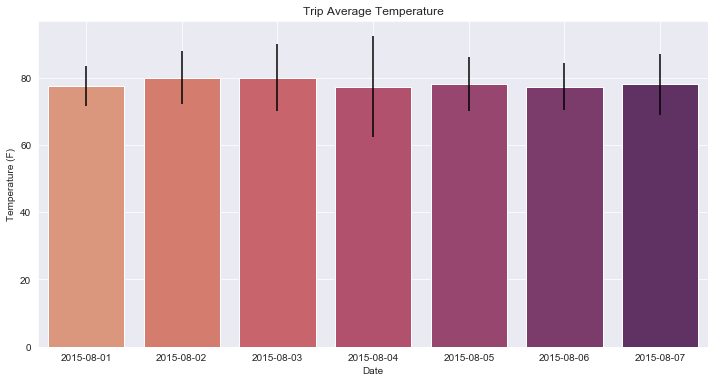

In [8]:
# Plot results as a bar chart per instructions in README
# Plot using 2015 Data

plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
plot = sns.barplot(x=df_2015["date"], 
                   y=df_2015["avg_1"], 
                   palette="flare", yerr=yerr_list)

plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.grid(True)
plt.title("Trip Average Temperature")
plt.show()

## Daily Rainfall Average

In [9]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation


## Daily Temperature Normals

In [10]:
def daily_normals(date):
    """Calculate Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals: tmin, tavg, and tmax
    
    """
    
    # TODO: write a function that meets the requirements specified above


In [11]:
# Calculate the daily normals for each day of your trip (inclusive)

start_date = '2017-08-01'
end_date = '2017-08-07'


In [12]:
# Load results into a dataframe per README instructions

In [13]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session